In [28]:
# Used libraries
import csv
import re
from brian2 import *
import numpy as np
from scipy.interpolate import interp1d
import brian2.numpy_ as np
import matplotlib.pyplot as plt
import time
import warnings
from scipy import interpolate


# Intrinsic random noise from the ML eNeuron

In this notebook we tried to model the random noise from an analog spiking Morris-Lecar eNeuron. The paper describes the jitter noise with equations:

![Texte alternatif](results/noise_model.jpg)


Consequently, to add this noise in our eNeuron model, we need to access: the current/the spiking rate/ and the index of the spike occurrence. The jitter noise affects the precise timing of the spike by causing it to occur either earlier or later. Consequently, random noise cannot be directly added through a refractory time since the latter is inherently positive. We have chosen to **incorporate the noise via the threshold level, enabling a direct translation to an earlier or later spike timing.**

At a given frequency of spiking rate, the potential action goes from v_reset to v_threshold in T=1/f seconds. Hence, a variation dt is the time spike is equivalent to a variation of voltage dv, with dv equals to:
    => **dv = (v_threshold-v_reset)*f*dt**


## Proof of concept:

#### => Threshold depending on the input current

WARNING    'i' is an internal variable of group 'neurongroup_2', but also exists in the run namespace with the value 12. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]


Starting simulation at t=0. s for a duration of 10. ms
10. ms (100%) simulated in < 1s


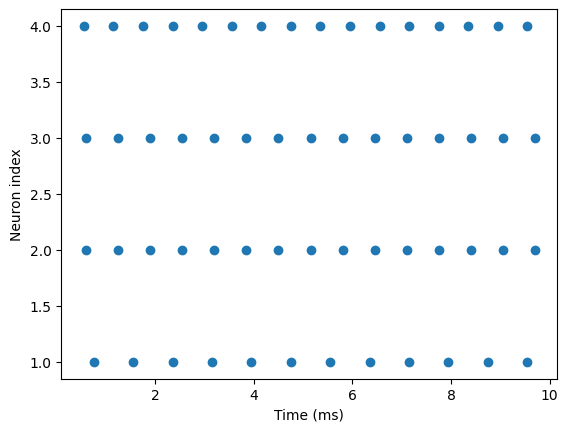

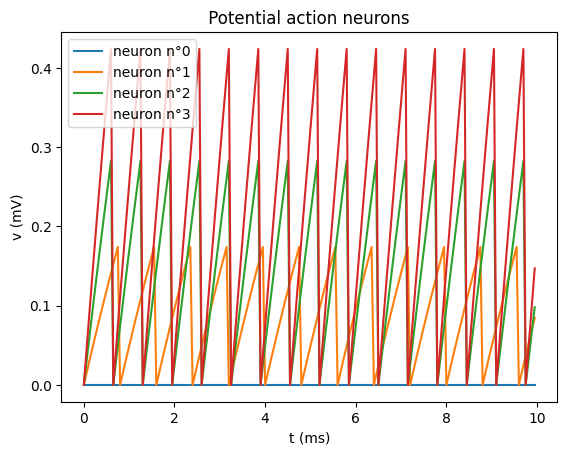

In [29]:
from brian2 import clear_cache
from brian2 import device
device.reinit()
start_scope()

defaultclock.dt = 50*us  


# Neuron parameters
tau = 10*ms
R = 5000*ohm
I0 = 1*amp

neuron_eqs_1= '''
dv/dt = (-2*v + R*I) / tau : volt
I : amp  # Input current
threshold = 0.1*(0.5*mV + 0.5*I*R) : volt  # threshold depending on the input current
'''


# Neuron group with variable threshold
neurons = NeuronGroup(5, neuron_eqs_1, threshold='v > threshold', reset='v = 0*volt', method='linear')
neurons.I = 'i*0.5*uA'

# Monitors
trace = StateMonitor(neurons, 'v', record=True)
spikemon = SpikeMonitor(neurons)


# Run simulation
run(10*ms, report='text', report_period = 60*second)


# Observation 
plot(spikemon.t/ms, spikemon.i, 'o')
xlabel('Time (ms)')
ylabel('Neuron index')
plt.show()

plot(trace.t/ms, trace[0].v/mV,label=f'neuron n°0')
plot(trace.t/ms, trace[1].v/mV,label=f'neuron n°1')
plot(trace.t/ms, trace[2].v/mV,label=f'neuron n°2')
plot(trace.t/ms, trace[3].v/mV,label=f'neuron n°3')
plt.legend()
title(' Potential action neurons ')
xlabel('t (ms)')
ylabel('v (mV)')

plt.show()


## Proof of concept:

threshold depending on the input current and on index spike occurrence

WARNING    'i' is an internal variable of group 'neurongroup_1', but also exists in the run namespace with the value 12. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]
WARNING    'idx_spk' is an internal variable of group 'neurongroup_1', but also exists in the run namespace with the value 99. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]


Starting simulation at t=0. s for a duration of 10. ms
10. ms (100%) simulated in < 1s


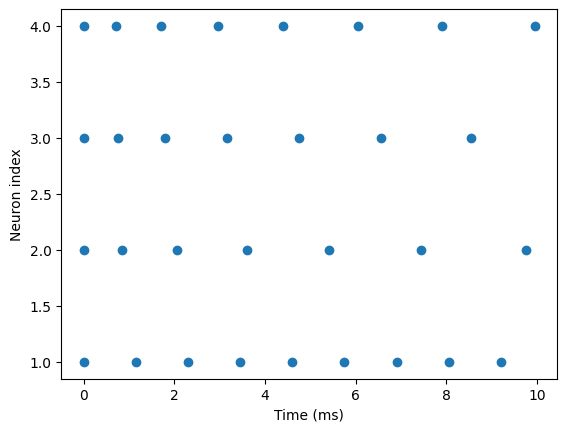

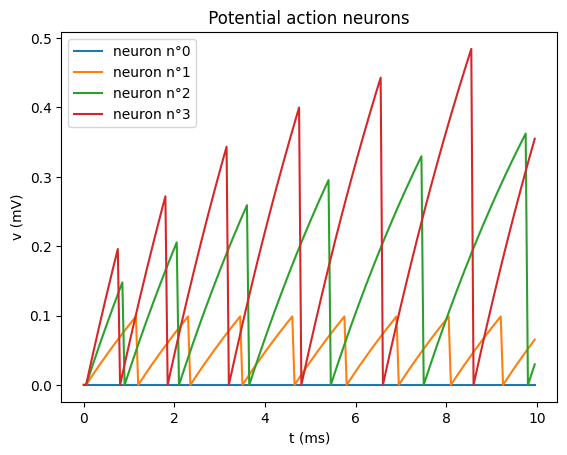

In [30]:
from brian2 import clear_cache
from brian2 import device
device.reinit()
start_scope()

defaultclock.dt = 50*us  

# Neuron parameters
tau = 10*ms
R = 5000*ohm
I0 = 1*amp

neuron_eqs_2= '''
dv/dt = (-2*v + R*I) / tau : volt
I : amp  # Input current
threshold = 0.1*(0.5*mV + 0.5*I*R)*sqrt(idx_spk) : volt  # threshold depending on the input current and on index spike occurrence
idx_spk : 1
'''

reset_eqs = '''
v = 0*mV
idx_spk = int(I>=0.3*uA)*(idx_spk) + 1 #reset the counter if the current is close to zero
'''

# Neuron group with variable threshold
neurons = NeuronGroup(5, neuron_eqs_2, threshold='v > threshold', reset=reset_eqs, method='linear')
neurons.I = 'i*0.2*uA'
#neurons.idx_spk = 1


# Monitors
trace = StateMonitor(neurons, 'v', record=True)
spikemon = SpikeMonitor(neurons)

# Run simulation
run(10*ms, report='text', report_period = 60*second)

# Observation

plot(spikemon.t/ms, spikemon.i, 'o')
xlabel('Time (ms)')
ylabel('Neuron index')
plt.show()

plot(trace.t/ms, trace[0].v/mV,label=f'neuron n°0')
plot(trace.t/ms, trace[1].v/mV,label=f'neuron n°1')
plot(trace.t/ms, trace[2].v/mV,label=f'neuron n°2')
plot(trace.t/ms, trace[3].v/mV,label=f'neuron n°3')
plt.legend()
title(' Potential action neurons ')
xlabel('t (ms)')
ylabel('v (mV)')

plt.show()


# Implementation of the intrinsic random noise from the ML eNeuron


In [31]:
# Importing the .csv file of firing rate depending on the input current from PSL results
csv_file_path = 'FT_augmented.csv' #Activation function 

input_current = []
spike_rate = []

# Open the CSV file
with open(csv_file_path, 'r') as file:
    csv_reader = csv.reader(file, delimiter='\t')
    # Skip the header row
    next(csv_reader)
    for row in csv_reader:
        values = re.split(r',', row[0])
        input_current.append(float(values[0]))
        spike_rate.append(float(values[1]))
        

        
def reducing_list(original_list, new_size):
    '''
        Function that reduces the size of a list and lessen the amount of computation
    In input:
        - Original_list: list you want to reduce in size
        - new_size: size desired for the list
    It returns:
        - Similar list with desired size
    '''
    original_size = len(original_list)
    if new_size >= original_size:
        return original_list  

    # Calculate the sampling interval
    interval = original_size / new_size

    # Sample elements at regular intervals
    new_list = [original_list[int(i * interval)] for i in range(new_size)]

    return new_list


nb_point_interpolation = 1001
# Force Brian to use numpy for code generation
prefs.codegen.target = 'numpy'

# Here I reduced the size of the data to accelerate the next processus
i_new = reducing_list(input_current,nb_point_interpolation)
f_new = reducing_list(spike_rate,nb_point_interpolation)

# Convert data to use with Brian2
i_new = i_new * amp  # Now x2 is in amperes
f_new = f_new * Hz      # Now y2 is in amperes (ensure this is the correct unit!)

interp_function = interp1d(i_new, f_new, fill_value='extrapolate')

@check_units(x=amp, result = Hz)
def y_interp_function(x):
    return interp_function(x)*Hz


WARNING    'frequency' is an internal variable of group 'neurongroup_2', but also exists in the run namespace with the value 0.81659385 * Mhertz. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]
WARNING    'idx_spk' is an internal variable of group 'neurongroup_2', but also exists in the run namespace with the value 99. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]


Starting simulation at t=0. s for a duration of 35. us
35. us (100%) simulated in 6s
Recorded threshold values over time: [[60. 60. 60. ... 60. 60. 60.]
 [60. 60. 60. ... 60. 60. 60.]
 [60. 60. 60. ... 60. 60. 60.]] mV


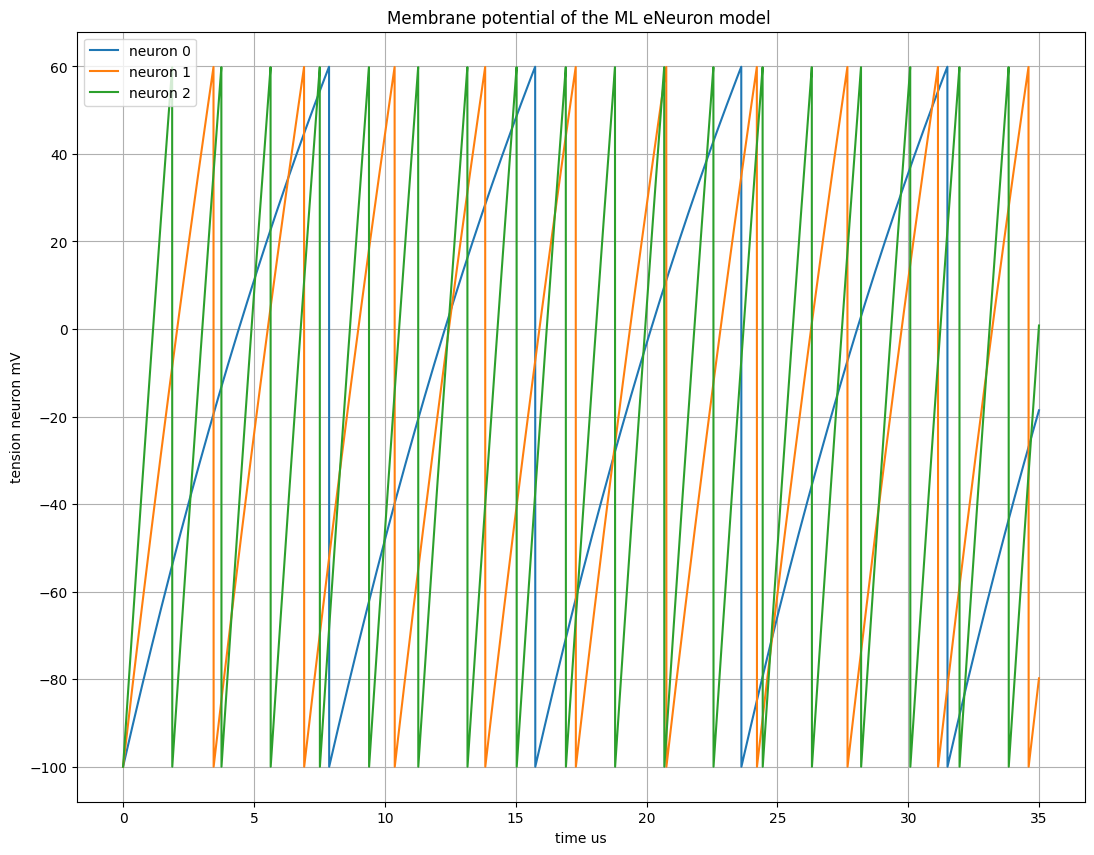

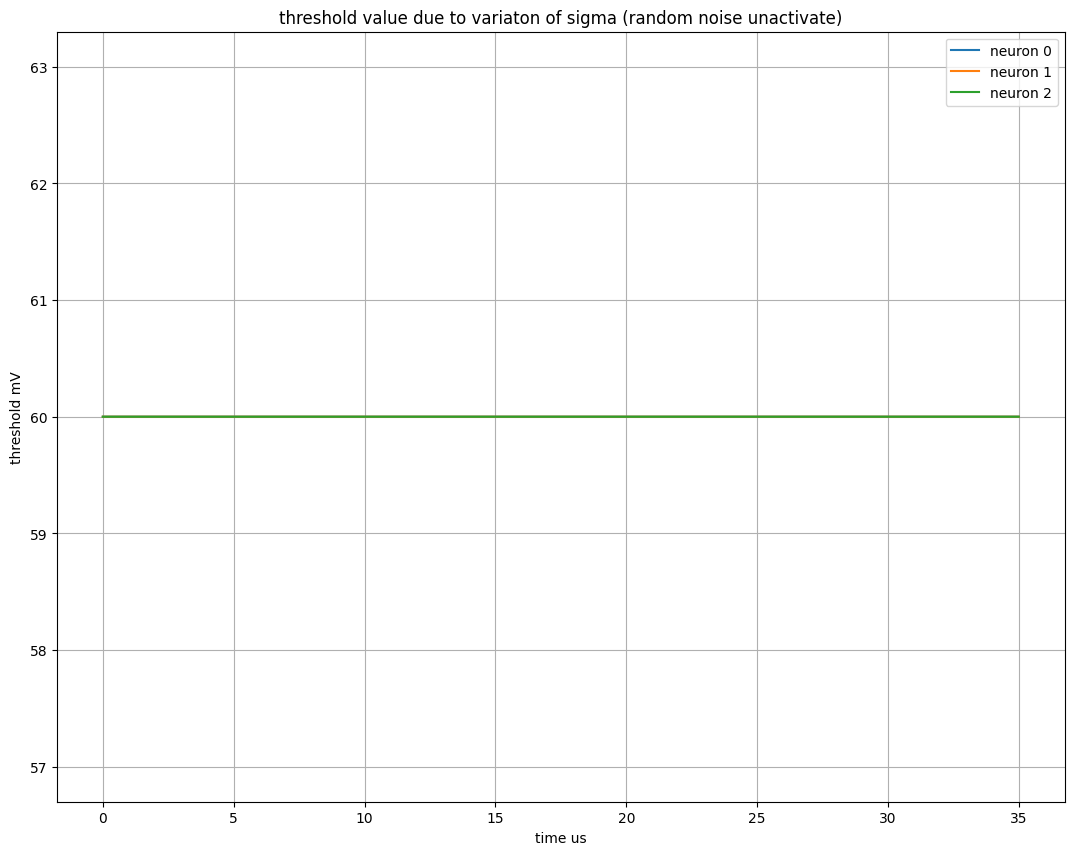

In [32]:
from brian2 import clear_cache
from brian2 import device
device.reinit()
start_scope()

# Simulation parameters
defaultclock.dt = 0.005*us  

min_input_current, max_input_current = min(i_new), max(i_new)
v_rest = -80*mV
v_threshold = 60*mV  
v_reset = -100*mV
refrac = 0*us
v0 = -40*mV  
tau = 0.5*ms
tau2 = 15*us
Rm = 5000*Mohm
I0=1*amp
a_v = 908.9270173535194
b_v = 207279.98480632046
alpha_e = 0.15
alpha_i = 0.04
beta_e = 1.9
beta_i = 0.5
x_threshold_v= 8.3e-11*amp
avoid_error = 0.01*pA #This constant exists only to make sure that there isn't in any case a log(0) which implies errors.
a_value = 73938062660774.66
q, R_ds,C_m = 1.6*1e-19*amp*second, 5*ohm, 5*1e-8*second/ohm

#dv/dt =  (v_rest - v)/tau2 +( int((I+I_exci) > firing_limit) * ((a + b * log(((I+I_exci)+ avoid_error)/firing_limit ))*I0*Rm)/ tau) : volt

avoid_error = 0.01*pA
c = 1
neuron_eqs_v1 = '''
dv/dt =  (v_rest - v) / tau2 + (( int((I + Ie+I_inhi) > x_threshold_v) *((a_v + b_v * log((1-int((I + Ie+I_inhi) > x_threshold_v))+int((I + Ie+I_inhi) > x_threshold_v)*(I+Ie+I_inhi+avoid_error)/(x_threshold_v) ))*I0)/a_value)*Rm) / tau : volt (unless refractory)
Ie =  alpha_e*ge * uS *(80*mV -c*v)           : amp
I_inhi =  alpha_i*gi * uS *(-120*mV -c*v)           : amp
I : amp
dge/dt = -ge/(beta_e*us)            : 1
dgi/dt = -gi/(beta_i*us)            : 1

threshold = v_threshold + int(noise_activity)*sqrt(q/(I+Ie+I_inhi)*(1/frequency + R_ds*C_m/pi))*randn()*(v_threshold-v_reset)*frequency*sqrt(idx_spk) : volt (constant over dt)
frequency = y_interp_function(I+Ie+I_inhi) : Hz (constant over dt)
idx_spk : 1
noise_activity : boolean (shared) # Activer/désactiver le bruit 
'''

reset_eqs = '''
v = v_reset
idx_spk = int((I+Ie+I_inhi)>=2*pA)*(idx_spk) + 1 # reset the index spike occurrence if the current is almost zero
'''

n = 3
input_group_v1 = NeuronGroup(n, neuron_eqs_v1, threshold='v >= threshold', reset=reset_eqs, refractory=0*us, method='heun')
input_group_v1.I = [0.2,0.5,2]*nA
input_group_v1.idx_spk = 1
input_group_v1.noise_activity = False


input_group_v1.v = -100*mV

trace1 = StateMonitor(input_group_v1, ['v','threshold'],record=True)





run(0.035 * ms, report='text', report_period = 60*second)

# Accessing and printing threshold values
print("Recorded threshold values over time:", trace1.threshold)


plt.figure(figsize=(13, 10))
for k in range(n):
    plot(trace1.t/us, trace1[k].v/mV,label=f'neuron {k}')
plt.xlabel('time us')
plt.ylabel('tension neuron mV')
plt.title("Membrane potential of the ML eNeuron model ")
plt.grid(True)
plt.legend()

plt.show()


plt.figure(figsize=(13, 10))
for k in range(n):
    plot(trace1.t/us, trace1[k].threshold/mV,label=f'neuron {k}')
plt.xlabel('time us')
plt.ylabel('threshold mV')
plt.title("threshold value due to variaton of sigma (random noise unactivate)")
plt.grid(True)
plt.legend()

plt.show()


Starting simulation at t=35. us for a duration of 35. us
35. us (100%) simulated in 4s
Recorded threshold values over time: [[60.51949729 63.35912541 60.76945531 ... 67.35171743 65.15066232
  62.15056117]
 [58.58599387 59.28524794 59.25588981 ... 64.50401153 70.57438644
  62.10646412]
 [59.63581921 61.40669887 60.89380054 ... 52.88951208 55.26870996
  59.71167173]] mV


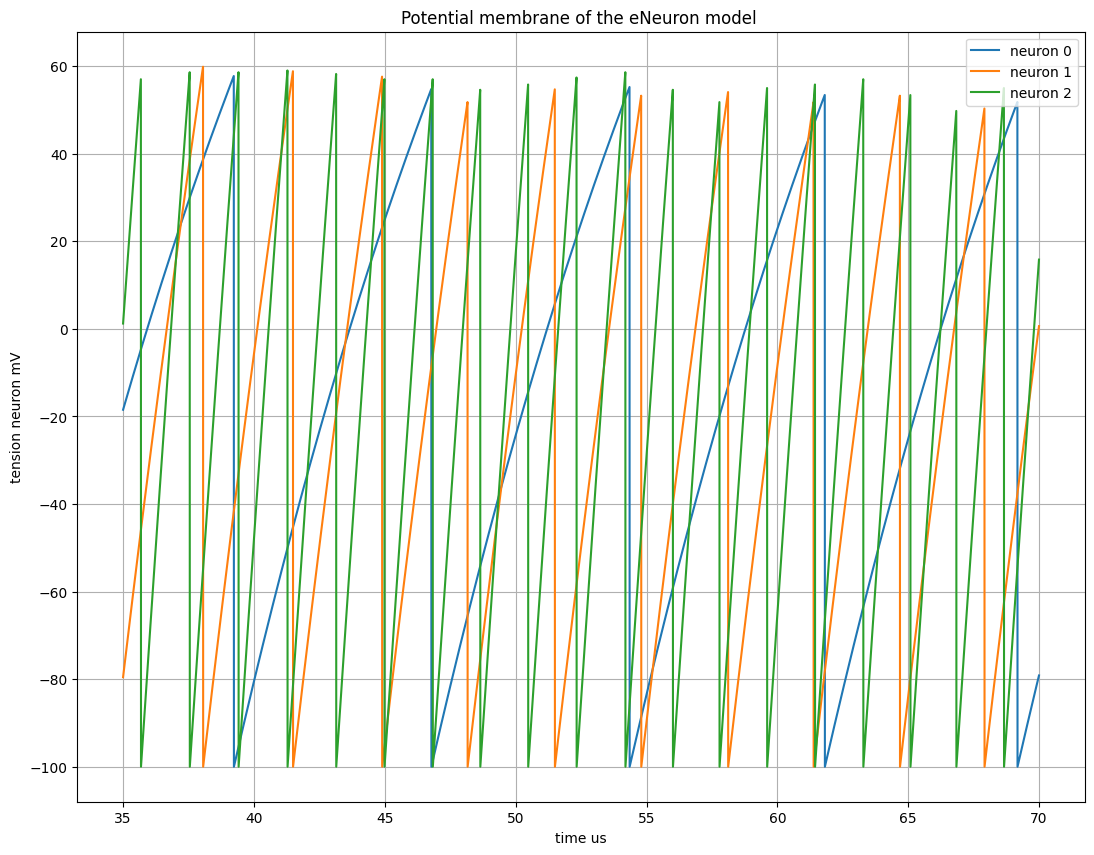

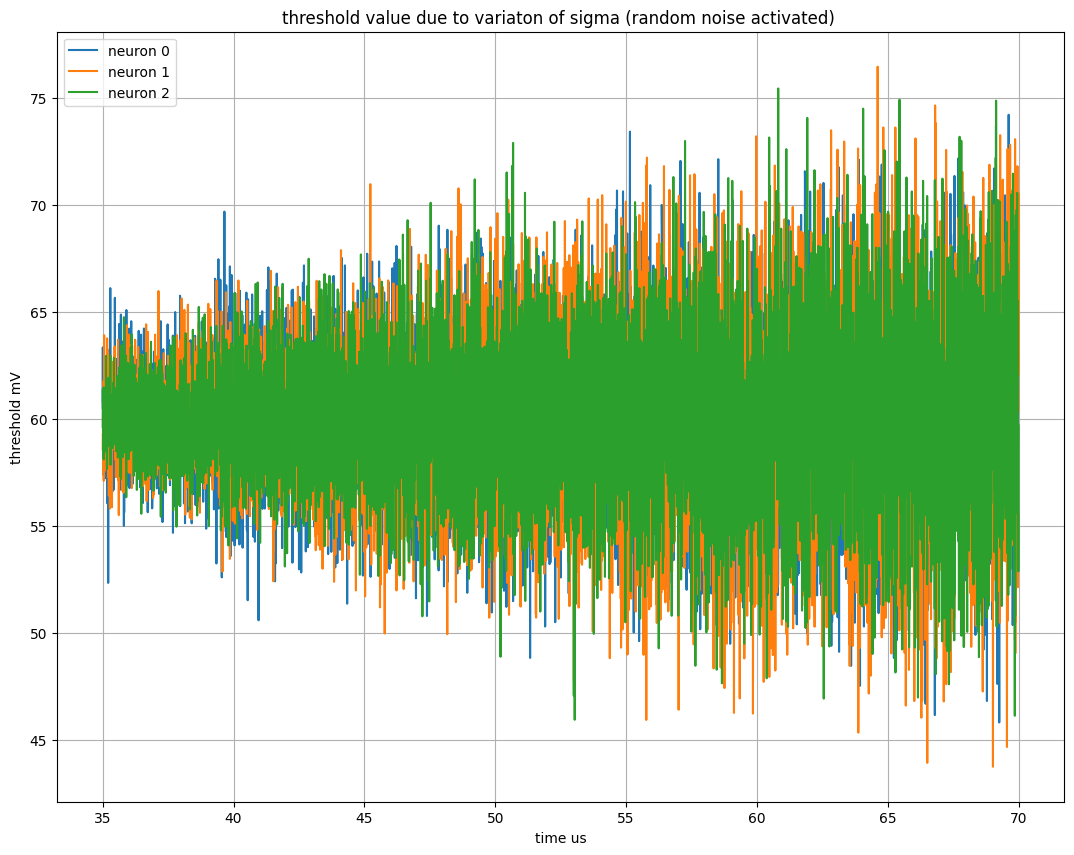

In [33]:
#input_group_v1.I = [0.2,0.5,2]*nA
input_group_v1.idx_spk = 1
input_group_v1.noise_activity = True

trace1 = StateMonitor(input_group_v1, ['v','threshold'],record=True)





run(0.035 * ms, report='text', report_period = 60*second)

# Accessing and printing threshold values
print("Recorded threshold values over time:", trace1.threshold)


plt.figure(figsize=(13, 10))
for k in range(n):
    plot(trace1.t/us, trace1[k].v/mV,label=f'neuron {k}')
plt.xlabel('time us')
plt.ylabel('tension neuron mV')
plt.title("Potential membrane of the eNeuron model ")
plt.grid(True)
plt.legend()

plt.show()


plt.figure(figsize=(13, 10))
for k in range(n):
    plot(trace1.t/us, trace1[k].threshold/mV,label=f'neuron {k}')
plt.xlabel('time us')
plt.ylabel('threshold mV')
plt.title("threshold value due to variaton of sigma (random noise activated) ")
plt.grid(True)
plt.legend()

plt.show()


# Applied to XOR problem

In [34]:
def reducing_list(original_list, new_size):
    '''
        Function that reduces the size of a list and lessen the amount of computation
    In input:
        - Original_list: list you want to reduce in size
        - new_size: size desired for the list
    It returns:
        - Similar list with desired size
    '''
    original_size = len(original_list)
    if new_size >= original_size:
        return original_list  

    # Calculate the sampling interval
    interval = original_size / new_size

    # Sample elements at regular intervals
    new_list = [original_list[int(i * interval)] for i in range(new_size)]

    return new_list

def extracting_eNeuron_behavior(csv_file_path,nb_point_interpolation):
    '''
        Function that extrates data from the transfer function of th eNeuron ML in order to define a linear-
        interpolation function
    In input:
        - path of the csv file containing the transfer function of the eNeuron
        - nb_point_interpolation: size of the interpolated list
    It returns:
        - i_new: x-axis of the interpolated function (amp)
        - f_new: y-axs of the interpolated function (Hz)
    '''

    input_current = []
    spike_rate = []

    # Open the CSV file
    with open(csv_file_path, 'r') as file:
        csv_reader = csv.reader(file, delimiter='\t')
        next(csv_reader)
        for row in csv_reader:
            values = re.split(r',', row[0])
            input_current.append(float(values[0]))
            spike_rate.append(float(values[1]))

    prefs.codegen.target = 'numpy'
    i_new = reducing_list(input_current,nb_point_interpolation)
    f_new = reducing_list(spike_rate,nb_point_interpolation)

    # Convert data to use with Brian2
    i_new = i_new * amp
    f_new = f_new * Hz
    
    return i_new, f_new

In [35]:
from brian2 import clear_cache
from brian2 import device
device.reinit()
start_scope()

# Simulation parameters
defaultclock.dt = 0.005*us  
time_per_sample = 100 * us
resting_time = 20 * us

# Defining the linear interpolation of the eNeuron ML behavior
i_new, f_new = extracting_eNeuron_behavior(csv_file_path='FT_augmented.csv',nb_point_interpolation=1101)
interp_function = interp1d(i_new, f_new, kind='linear', fill_value='extrapolate',assume_sorted=True)

@check_units(x=amp, result = Hz)
def y_interp_function(x):
    return interp_function(x)*Hz

#Model parameters
v_rest = -80*mV
v_threshold = 60*mV  
v_std_thresh = 0*mV #standart deviation for the threshold value (randn :drawn from the standard normal distribution, i.e. with mean 0 and standard deviation 1) 
v_reset = -100*mV
v0 = -40*mV  
tau = 500*us
tau2 = 15*us
Rm = 5000*Mohm
I0=1*amp

a_v = 908.9270173535194
b_v = 207279.98480632046
a_value = 73938062660774.66

a_v = 1126.6343973469338
b_v = 169200.45773494235
a_value = 6.23667974e13

x_threshold_v= 8.3e-11*amp
q, R_ds,C_m,scale = 1.602176634*1e-19*amp*second, 1*1e6*ohm, 9.83*1e-15*second/ohm,10
avoid_error = 0.01*pA
frequency_min = 0.1*Hz
refrac = 0*us
alpha_e = 0.15
alpha_i = 0.04
beta_e = 1.9
beta_i = 0.5
avoid_error = 0.01*pA

V_x, V_y, V_z= 8*mV,62*mV,90*mV
R_x = Rm*(V_x/mV)/(15/60)/(abs(v_threshold/mV)+abs(v_reset/mV))  #New resistance for rising till V_a
R_y = Rm*(V_y/mV)/(35/60)/(abs(v_threshold/mV)+abs(v_reset/mV)) #New resistance for rising till V_b
R_z = Rm*(V_z/mV)/(10/60)/(abs(v_threshold/mV)+abs(v_reset/mV)) #New resistance for rising till V_b
k_redres = 0.007704519252680564
k_redres = -0.0018141002616710589




@check_units(x=amp, result = amp)
def max_function_I(x):
    #print(" in function max current, x = ",x)
    y = [max(i,avoid_error) for i in x]
    #print(" AFTER PROcess in function max current, x = ",x)
    return y



# This model use a constant Resistance and a log approximation
neuron_eqs_v1 = '''
dv/dt =  (v_rest - v) / tau2 + ( int(I_total > x_threshold_v) *(I_syn*I0)/(a_value*Hz)*Rm) / tau : volt (unless refractory)
I_total = clip(Ie + I_inhi + I, 0*nA, 10*nA) : amp
I_syn = Hz*(a_v + b_v * log((1-int(I_total > x_threshold_v))+int(I_total > x_threshold_v)*(I_total+avoid_error)/(x_threshold_v) )) : Hz (constant over dt)
Ie =  alpha_e*ge * uS *(80*mV -v)           : amp
I_inhi =  alpha_i*gi * uS *(-120*mV -v)           : amp
I : amp
dge/dt = -ge/(beta_e*us)            : 1
dgi/dt = -gi/(beta_i*us)            : 1
Rm = (R_x)*int(v<=(v_reset+V_x)) + (R_y)*int(v<=(v_reset+V_x+V_y))*(1-int(v<(v_reset+V_x))) + (R_z)*int(v>(v_reset+V_x+V_y)) : ohm

threshold = v_threshold + int(noise_activity)*(int(I_syn>frequency_min)*sqrt(scale*q/(I_total+avoid_error)*(1/(I_syn+frequency_min) + R_ds*C_m/pi)))*randn()*(v_threshold-v_reset)*I_syn*sqrt(idx_spk) : volt (constant over dt)
idx_spk : 1
noise_activity : boolean (shared) # (un)Activate the noise
'''

neuron_eqs_v3 = '''
dv/dt = (v_rest - v) / tau2 + redress*((I_syn*I0/(a_value*Hz))*Rm)/ tau : volt (unless refractory)
I_total = clip(Ie + I_inhi + I, 0*nA, 15*nA) : amp
I_syn = y_interp_function(I_total) : Hz (constant over dt)
Ie =  alpha_e*ge * uS *(80*mV -v)           : amp
I_inhi =  alpha_i*gi * uS *(-120*mV -v)           : amp
I : amp
redress = 1+ k_redres*I_total/max_input_current     : 1
dge/dt = -ge/(beta_e*us)            : 1
dgi/dt = -gi/(beta_i*us)            : 1
Rm = (R_x)*int(v<=(v_reset+V_x)) + (R_y)*int(v<=(v_reset+V_x+V_y))*(1-int(v<(v_reset+V_x))) + (R_z)*int(v>(v_reset+V_x+V_y)) : ohm

threshold = v_threshold + int(noise_activity)*sigma*randn()*(v_threshold-v_reset)*frequency*sqrt(idx_spk) : volt (constant over dt)
frequency = I_syn : Hz (constant over dt)
sigma = int(I_total>=7*pA)*sqrt(scale*q/(I_total+avoid_error)*(1/(frequency+frequency_min) + R_ds*C_m/pi)) : second (constant over dt) #standart deviation
idx_spk : 1
noise_activity : boolean (shared) # (un)Activate the noise
'''

reset_eqs = '''
v = v_reset
idx_spk = int(I_total>=7*pA)*(idx_spk) + 1 # reset the index spike occurrence if the current is almost zero
'''



#STDP parameters
tau_stdp = 1.88116837
mag_stdp = 0.007070372048

taupre = tau_stdp*us
taupost = taupre
wmax = 1
dApre = mag_stdp
dApost = -dApre * taupre / taupost * 1.05

stdp_eqs_exci = '''
    w : 1
    lr : 1 (shared)
    dApre/dt = -Apre / taupre : 1 (event-driven)
    dApost/dt = -Apost / taupost : 1 (event-driven)
'''
pre_eqs_exci='''
    ge_post += w
    Apre += dApre
    w = clip(w + lr*Apost, 0, wmax)
'''
post_eqs_exci='''
    Apost += dApost
    w = clip(w + lr*Apre, 0, wmax)
'''

stdp_eqs_inhi = '''
    w : 1
    lr : 1 (shared)
    dApre/dt = -Apre / taupre : 1 (event-driven)
    dApost/dt = -Apost / taupost : 1 (event-driven)
'''
pre_eqs_inhi='''
    gi_post += w
    Apre += dApre
    w = clip(w + lr*Apost, 0, wmax)
'''
post_eqs_inhi='''
    Apost += dApost
    w = clip(w + lr*Apre, 0, wmax)
'''

synapse_model = "w : 1"

In [36]:
 
n_input = 2
input_group = NeuronGroup(n_input, neuron_eqs_v3,  threshold='v >= threshold', reset=reset_eqs, refractory=0*us, method='heun')
input_group.idx_spk = 1
input_group.noise_activity = True

n_output = 13
output_group = NeuronGroup(n_output, neuron_eqs_v3, threshold='v >= threshold', reset=reset_eqs, refractory=0*us, method='heun')
output_group.idx_spk = 1
output_group.noise_activity = True



input_sy_exci = Synapses(input_group, output_group, model=stdp_eqs_exci, on_pre=pre_eqs_exci, on_post=post_eqs_exci)
input_sy_exci.connect(True)
input_sy_exci.lr = 0.5
input_sy_exci.w = 'rand() * wmax * 0.8 + 0.1*wmax'
input_sy_exci.delay = 'rand()*0*us'

input_sy_inhi = Synapses(input_group, output_group, model=stdp_eqs_inhi, on_pre=pre_eqs_inhi, on_post=post_eqs_inhi)
input_sy_inhi.connect(True)
input_sy_inhi.lr = 0.5
input_sy_inhi.w = 'rand() * wmax * 0.5 + 0.1*wmax'
input_sy_inhi.delay = 'rand()*0*us'

wta_sy = Synapses(output_group, output_group, model=synapse_model, on_pre='gi_post += w')
wta_sy.connect(condition='i != j')
wta_sy.w = 'rand() * wmax * 1.8 + 0.8*wmax'
input_sy_inhi.delay = 'rand()*0*us'


M_input_exci = StateMonitor(input_sy_exci, ['w'], record=True)
M_input_inhi = StateMonitor(input_sy_inhi, ['w'], record=True)



# Monitors for input neurons
input_spike_monitor = SpikeMonitor(input_group)
input_state_monitor = StateMonitor(input_group, ['v','I','threshold','idx_spk'], record=True)


# Monitors for output neuron
output_spike_monitor = SpikeMonitor(output_group)
output_state_monitor = StateMonitor(output_group, ['v','I_total','Ie','I_inhi','threshold','idx_spk'], record=True)

WARNING    'i' is an internal variable of group 'synapses_2', but also exists in the run namespace with the value 12. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]


In [37]:
input_group.v = v_rest
input_group.I = [2*nA,0.3*nA] #equivalent to binary input [1,0]
input_group.v = v_rest
output_group.v = v_rest

# Run the simulation
defaultclock.dt = 0.015*us  
duration = 100*us
run(duration, report='text', report_period = 60*second)


input_group.I = [0*nA,0*nA]
input_group.noise_activity = False
output_group.noise_activity = False
# Run the simulation
duration = 20*us
run(duration, report='text', report_period = 60*second)
input_group.v = v_rest
output_group.v = v_rest
input_group.noise_activity = True
output_group.noise_activity = True



input_group.I = [2*nA,2*nA] # equivalent to binary input [1,1]
input_group.v = v_rest
output_group.v = v_rest
input_group.idx_spk = 1
output_group.idx_spk = 1


# Run the simulation
duration = 100*us
run(duration, report='text', report_period = 60*second)


WARNING    'I_total' is an internal variable of group 'neurongroup_3', but also exists in the run namespace with the value 10. * namp. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]
WARNING    'I_total' is an internal variable of group 'neurongroup', but also exists in the run namespace with the value 10. * namp. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]
WARNING    'idx_spk' is an internal variable of group 'neurongroup_3', but also exists in the run namespace with the value 99. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]
WARNING    'idx_spk' is an internal variable of group 'neurongroup', but also exists in the run namespace with the value 99. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]


Starting simulation at t=0. s for a duration of 100. us
100. us (100%) simulated in 5s
Starting simulation at t=100. us for a duration of 20. us
20. us (100%) simulated in < 1s
Starting simulation at t=120. us for a duration of 100. us
100. us (100%) simulated in 4s


## Input

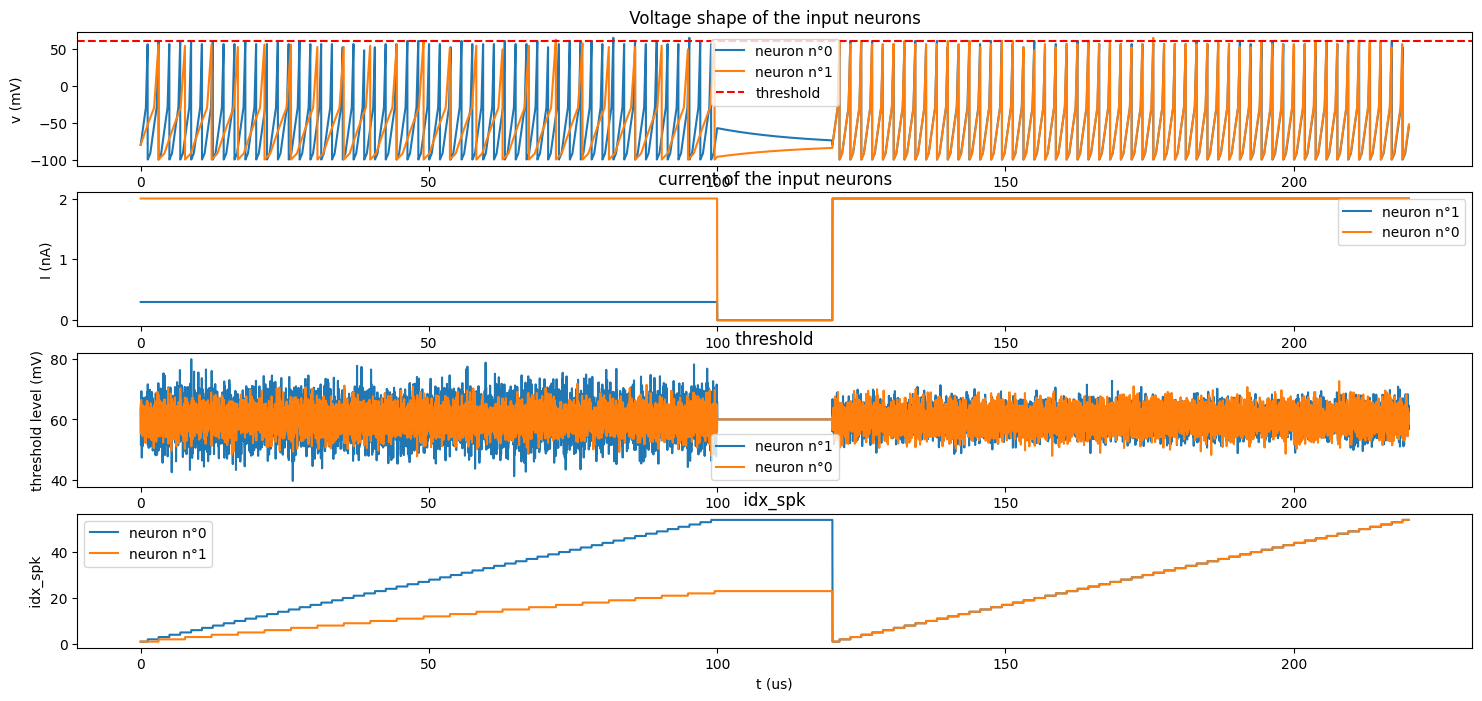

In [38]:
plt.figure(figsize=(18, 8))

plt.subplot(411)
plot(input_state_monitor.t/us, input_state_monitor[0].v/mV,label='neuron n°0')
plot(input_state_monitor.t/us, input_state_monitor[1].v/mV,label='neuron n°1')
plt.axhline(y=v_threshold/mV, color='r', linestyle='--',label='threshold')
plt.legend()
title(' Voltage shape of the input neurons ')
xlabel('t (us)')
ylabel('v (mV)')

plt.subplot(412)
plot(input_state_monitor.t/us, input_state_monitor[1].I/nA,label='neuron n°1')
plot(input_state_monitor.t/us, input_state_monitor[0].I/nA,label='neuron n°0')
plt.legend()
title(' current of the input neurons ')
xlabel('t (us)')
ylabel('I (nA)')


plt.subplot(413)
for i in range(n_input-1,-1,-1):
    plot(input_state_monitor.t/us, input_state_monitor[i].threshold/mV,label=f'neuron n°{i}')
plt.legend()
title(' threshold ')
xlabel('t (us)')
ylabel('threshold level (mV)')

plt.subplot(414)
for i in range(n_input):
    plot(input_state_monitor.t/us, input_state_monitor[i].idx_spk,label=f'neuron n°{i}')
plt.legend()
title(' idx_spk ')
xlabel('t (us)')
ylabel(' idx_spk ')

plt.show()


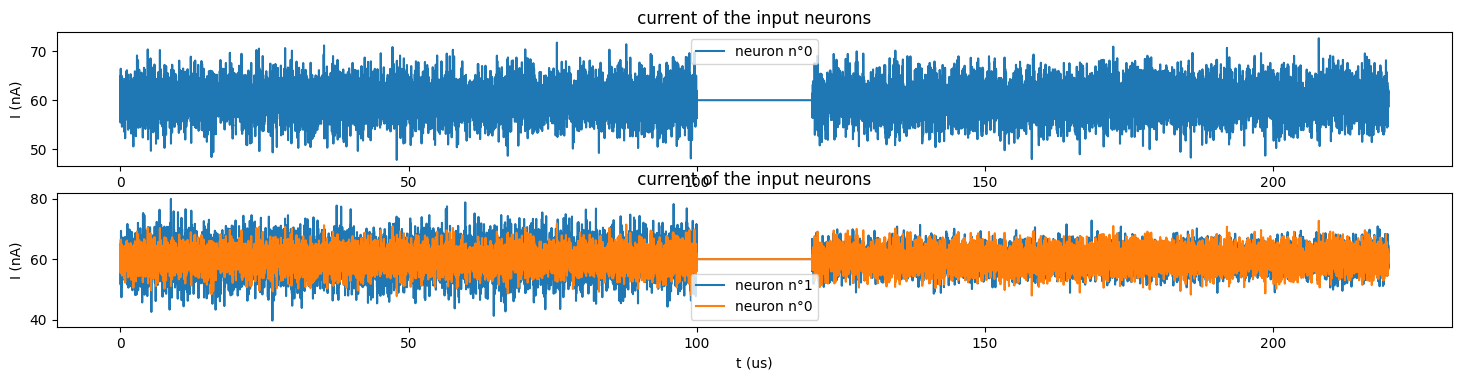

In [39]:
plt.figure(figsize=(18, 8))

plt.subplot(411)
plot(input_state_monitor.t/us, input_state_monitor[0].threshold/mV,label='neuron n°0')
plt.legend()
title(' threshold of the input neurons ')
xlabel('t (us)')
ylabel('threshold (mV)')

plt.subplot(412)
plot(input_state_monitor.t/us, input_state_monitor[1].threshold/mV,label='neuron n°1')
plot(input_state_monitor.t/us, input_state_monitor[0].threshold/mV,label='neuron n°0')
plt.legend()
title(' threshold of the input neurons ')
xlabel('t (us)')
ylabel('threshold (mV)')



plt.show()


## Output

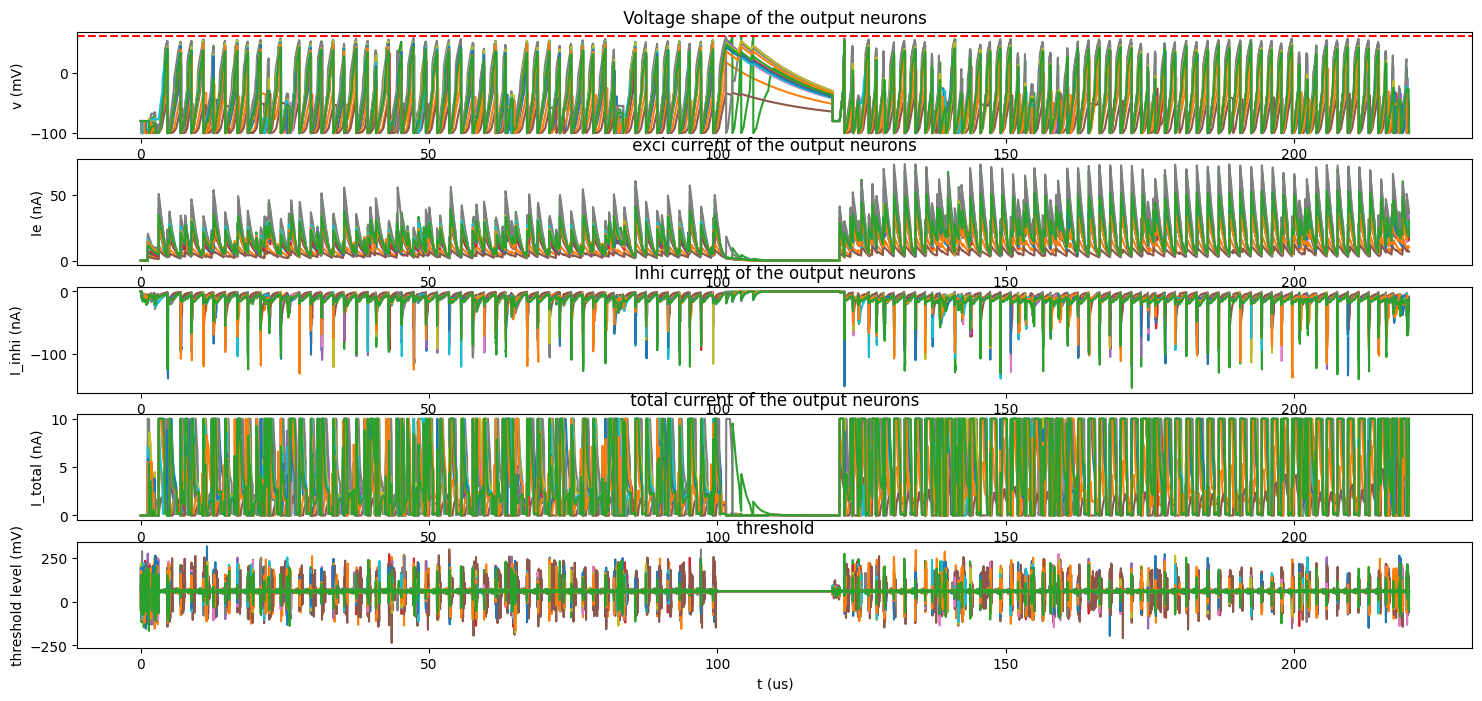

In [40]:
plt.figure(figsize=(18, 8))

plt.subplot(511)
for i in range(n_output):
    plot(output_state_monitor.t/us, output_state_monitor[i].v/mV,label=f'neuron n°{i}')
plt.axhline(y=v_threshold/mV, color='r', linestyle='--',label='threshold')
#plt.legend()
title(' Voltage shape of the output neurons ')
xlabel('t (us)')
ylabel('v (mV)')

plt.subplot(512)
for i in range(n_output):
    plot(output_state_monitor.t/us, output_state_monitor[i].Ie/nA,label=f'neuron n°{i}')
#plt.legend()
title(' exci current of the output neurons ')
xlabel('t (us)')
ylabel('Ie (nA)')

plt.subplot(513)
for i in range(n_output):
    plot(output_state_monitor.t/us, output_state_monitor[i].I_inhi/nA,label=f'neuron n°{i}')
#plt.legend()
title(' Inhi current of the output neurons ')
xlabel('t (us)')
ylabel('I_inhi (nA)')

plt.subplot(514)
for i in range(n_output):
    plot(output_state_monitor.t/us, output_state_monitor[i].I_total/nA,label=f'neuron n°{i}')
#plt.legend()
title(' total current of the output neurons ')
xlabel('t (us)')
ylabel('I_total (nA)')

plt.subplot(515)
for i in range(n_output):
    plot(output_state_monitor.t/us, output_state_monitor[i].threshold/mV,label=f'neuron n°{i}')
#plt.legend()
title(' threshold ')
xlabel('t (us)')
ylabel('threshold level (mV)')

plt.show()


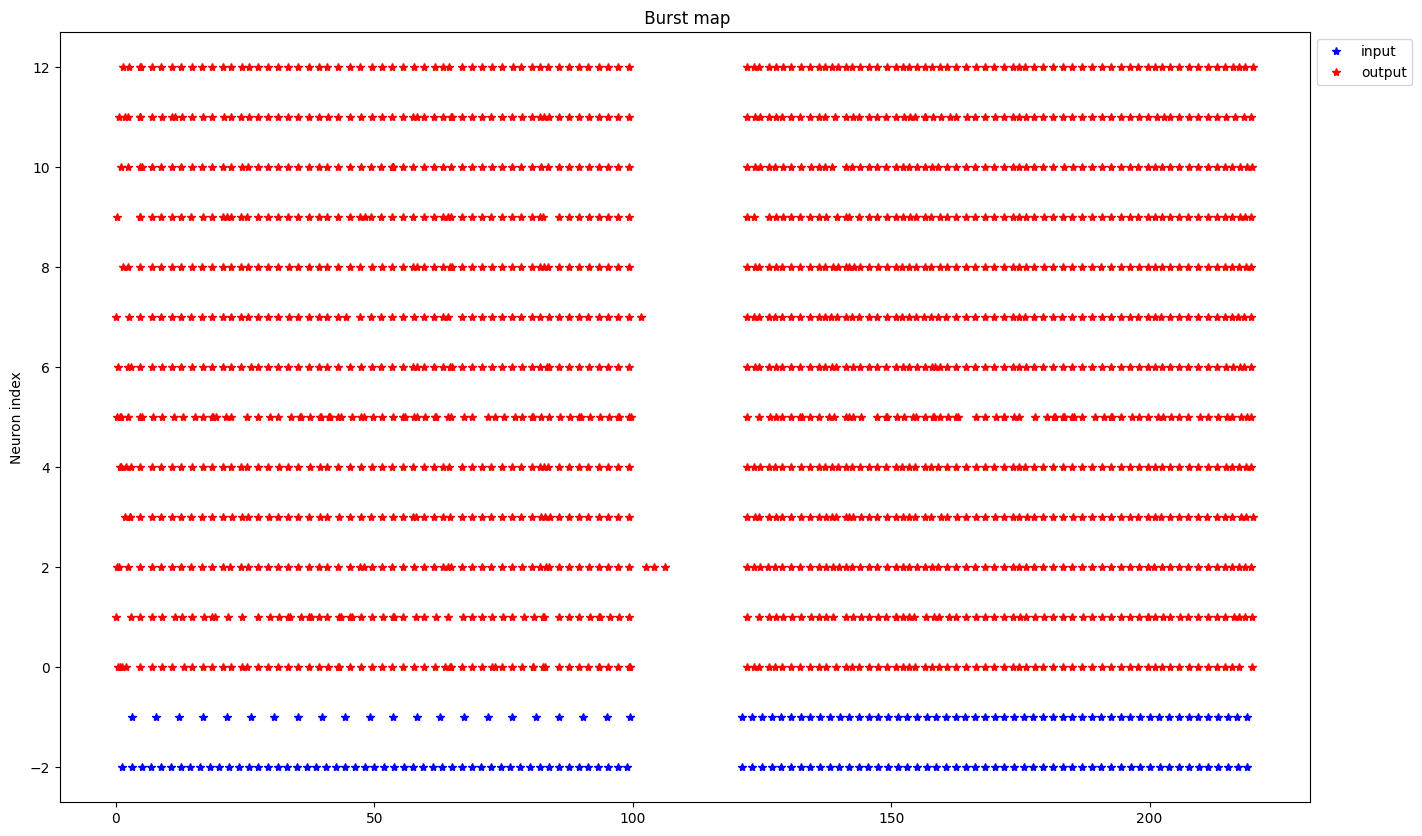

In [41]:
plt.figure(figsize=(20, 10))
plot(input_spike_monitor.t/us, input_spike_monitor.i+np.array([-n_input for i in range(len(input_spike_monitor.i))]), '*b',label='input')
plot(output_spike_monitor.t/us, output_spike_monitor.i, '*r',label='output')
plt.ylabel('Neuron index')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.subplots_adjust(right=0.75)
plt.title(" Burst map")
plt.show()

## If we do not desactivate the noise during resting_time:

In [42]:
from brian2 import clear_cache
from brian2 import device
device.reinit()
start_scope()


n_input = 2
input_group = NeuronGroup(n_input, neuron_eqs_v1,  threshold='v >= threshold', reset=reset_eqs, refractory=0*us, method='heun')
input_group.idx_spk = 1
input_group.noise_activity = True

n_output = 13
output_group = NeuronGroup(n_output, neuron_eqs_v1, threshold='v >= threshold', reset=reset_eqs, refractory=0*us, method='heun')
output_group.idx_spk = 1
output_group.noise_activity = True



input_sy_exci = Synapses(input_group, output_group, model=stdp_eqs_exci, on_pre=pre_eqs_exci, on_post=post_eqs_exci)
input_sy_exci.connect(True)
input_sy_exci.lr = 0.5
input_sy_exci.w = 'rand() * wmax * 0.8 + 0.1*wmax'
input_sy_exci.delay = 'rand()*0*us'

input_sy_inhi = Synapses(input_group, output_group, model=stdp_eqs_inhi, on_pre=pre_eqs_inhi, on_post=post_eqs_inhi)
input_sy_inhi.connect(True)
input_sy_inhi.lr = 0.5
input_sy_inhi.w = 'rand() * wmax * 0.5 + 0.1*wmax'
input_sy_inhi.delay = 'rand()*0*us'

wta_sy = Synapses(output_group, output_group, model=synapse_model, on_pre='gi_post += w')
wta_sy.connect(condition='i != j')
wta_sy.w = 'rand() * wmax * 1.8 + 0.8*wmax'
input_sy_inhi.delay = 'rand()*0*us'


M_input_exci = StateMonitor(input_sy_exci, ['w'], record=True)
M_input_inhi = StateMonitor(input_sy_inhi, ['w'], record=True)



# Monitors for input neurons
input_spike_monitor = SpikeMonitor(input_group)
input_state_monitor = StateMonitor(input_group, ['v', 'I','threshold'], record=True)


# Monitors for output neuron
output_spike_monitor = SpikeMonitor(output_group)
output_state_monitor = StateMonitor(output_group, ['v','Ie','I_inhi','threshold'], record=True)

In [43]:
input_group.v = v_rest
input_group.I = [2*nA,0.3*nA] #equivalent to binary input [1,0]
input_group.v = v_rest
output_group.v = v_rest

# Run the simulation
defaultclock.dt = 0.015*us  
duration = 100*us
run(duration, report='text', report_period = 60*second)


input_group.I = [0*nA,0*nA]
# Run the simulation
duration = 20*us
run(duration, report='text', report_period = 60*second)
input_group.v = v_rest
output_group.v = v_rest




input_group.I = [2*nA,2*nA] # equivalent to binary input [1,1]
input_group.v = v_rest
output_group.v = v_rest



# Run the simulation
duration = 100*us
run(duration, report='text', report_period = 60*second)


WARNING    'I_total' is an internal variable of group 'neurongroup_4', but also exists in the run namespace with the value 10. * namp. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]
WARNING    'I_total' is an internal variable of group 'neurongroup_5', but also exists in the run namespace with the value 10. * namp. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]
WARNING    'idx_spk' is an internal variable of group 'neurongroup_4', but also exists in the run namespace with the value 99. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]
WARNING    'idx_spk' is an internal variable of group 'neurongroup_5', but also exists in the run namespace with the value 99. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]


Starting simulation at t=0. s for a duration of 100. us
100. us (100%) simulated in 5s
Starting simulation at t=100. us for a duration of 20. us
20. us (100%) simulated in 1s
Starting simulation at t=120. us for a duration of 100. us
100. us (100%) simulated in 4s


## input

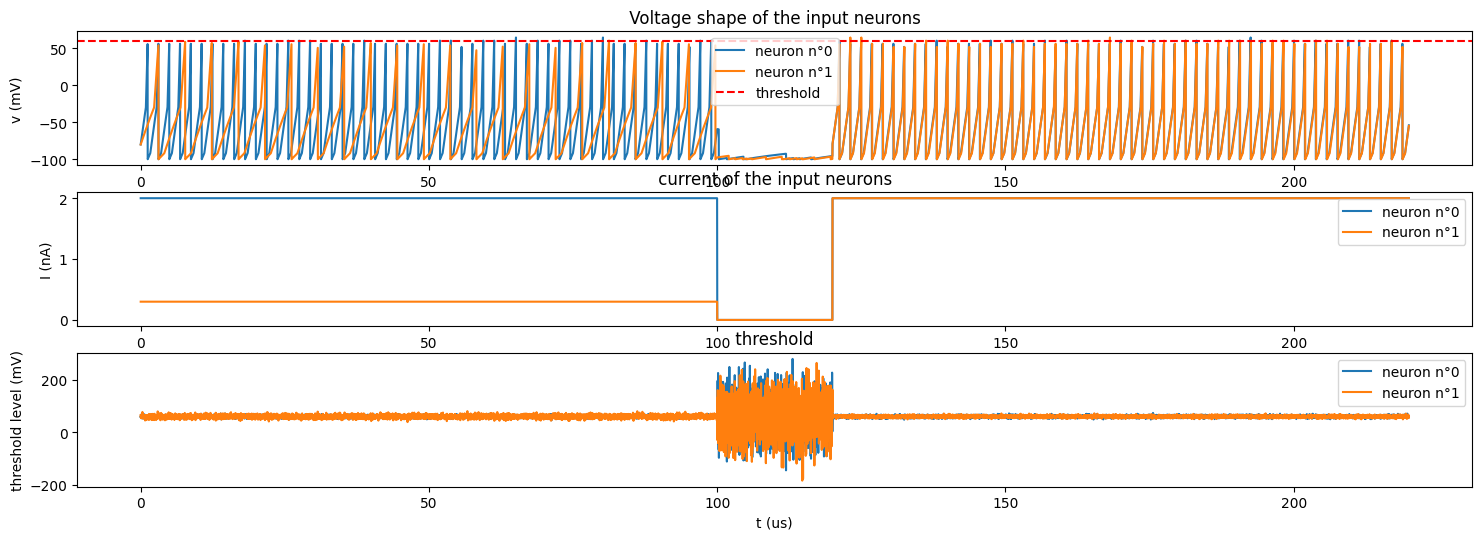

In [44]:
plt.figure(figsize=(18, 8))

plt.subplot(411)
plot(input_state_monitor.t/us, input_state_monitor[0].v/mV,label='neuron n°0')
plot(input_state_monitor.t/us, input_state_monitor[1].v/mV,label='neuron n°1')
plt.axhline(y=v_threshold/mV, color='r', linestyle='--',label='threshold')
plt.legend()
title(' Voltage shape of the input neurons ')
xlabel('t (us)')
ylabel('v (mV)')

plt.subplot(412)
plot(input_state_monitor.t/us, input_state_monitor[0].I/nA,label='neuron n°0')
plot(input_state_monitor.t/us, input_state_monitor[1].I/nA,label='neuron n°1')
plt.legend()
title(' current of the input neurons ')
xlabel('t (us)')
ylabel('I (nA)')


plt.subplot(413)
for i in range(n_input):
    plot(input_state_monitor.t/us, input_state_monitor[i].threshold/mV,label=f'neuron n°{i}')
plt.legend()
title(' threshold ')
xlabel('t (us)')
ylabel('threshold level (mV)')


plt.show()


## Output

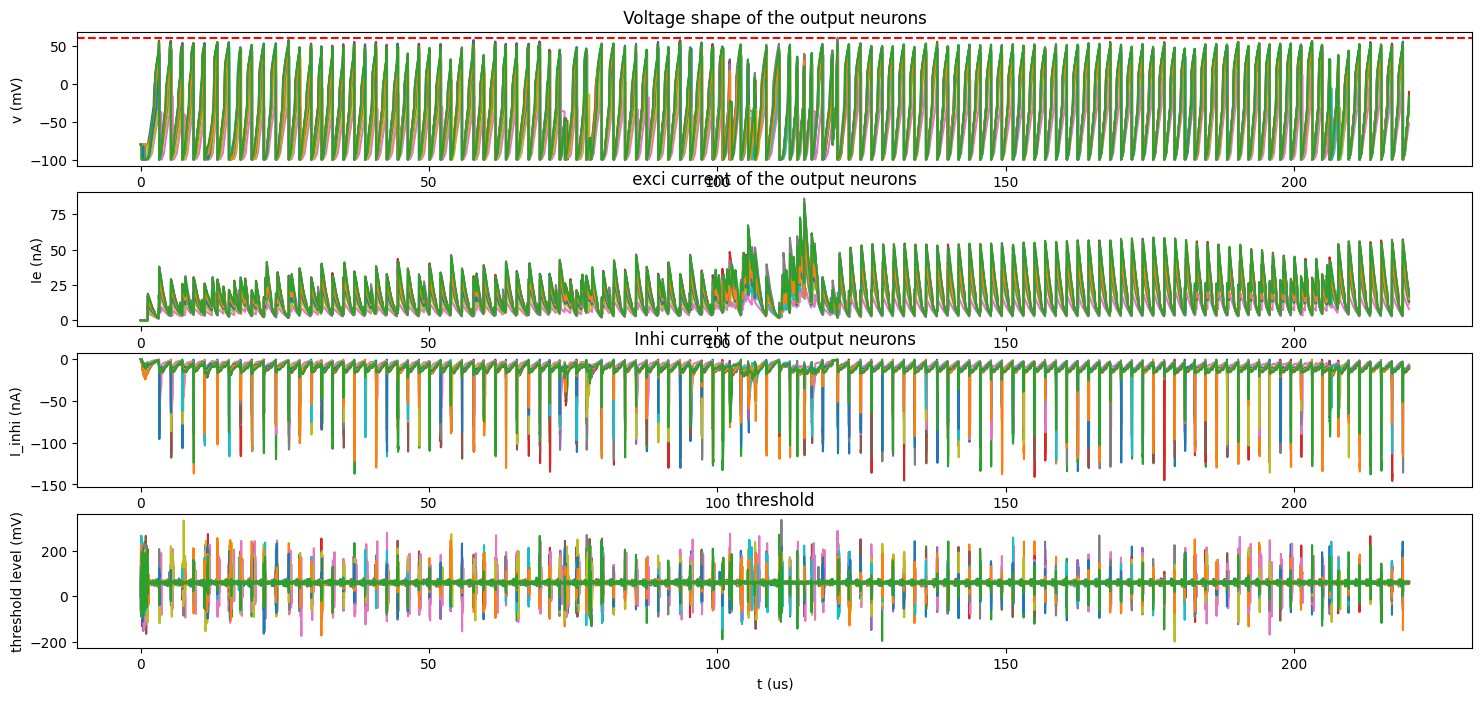

In [45]:
plt.figure(figsize=(18, 8))

plt.subplot(411)
for i in range(n_output):
    plot(output_state_monitor.t/us, output_state_monitor[i].v/mV,label=f'neuron n°{i}')
plt.axhline(y=v_threshold/mV, color='r', linestyle='--',label='threshold')
#plt.legend()
title(' Voltage shape of the output neurons ')
xlabel('t (us)')
ylabel('v (mV)')

plt.subplot(412)
for i in range(n_output):
    plot(output_state_monitor.t/us, output_state_monitor[i].Ie/nA,label=f'neuron n°{i}')
#plt.legend()
title(' exci current of the output neurons ')
xlabel('t (us)')
ylabel('Ie (nA)')

plt.subplot(413)
for i in range(n_output):
    plot(output_state_monitor.t/us, output_state_monitor[i].I_inhi/nA,label=f'neuron n°{i}')
#plt.legend()
title(' Inhi current of the output neurons ')
xlabel('t (us)')
ylabel('I_inhi (nA)')

plt.subplot(414)
for i in range(n_output):
    plot(output_state_monitor.t/us, output_state_monitor[i].threshold/mV,label=f'neuron n°{i}')
#plt.legend()
title(' threshold ')
xlabel('t (us)')
ylabel('threshold level (mV)')

plt.show()


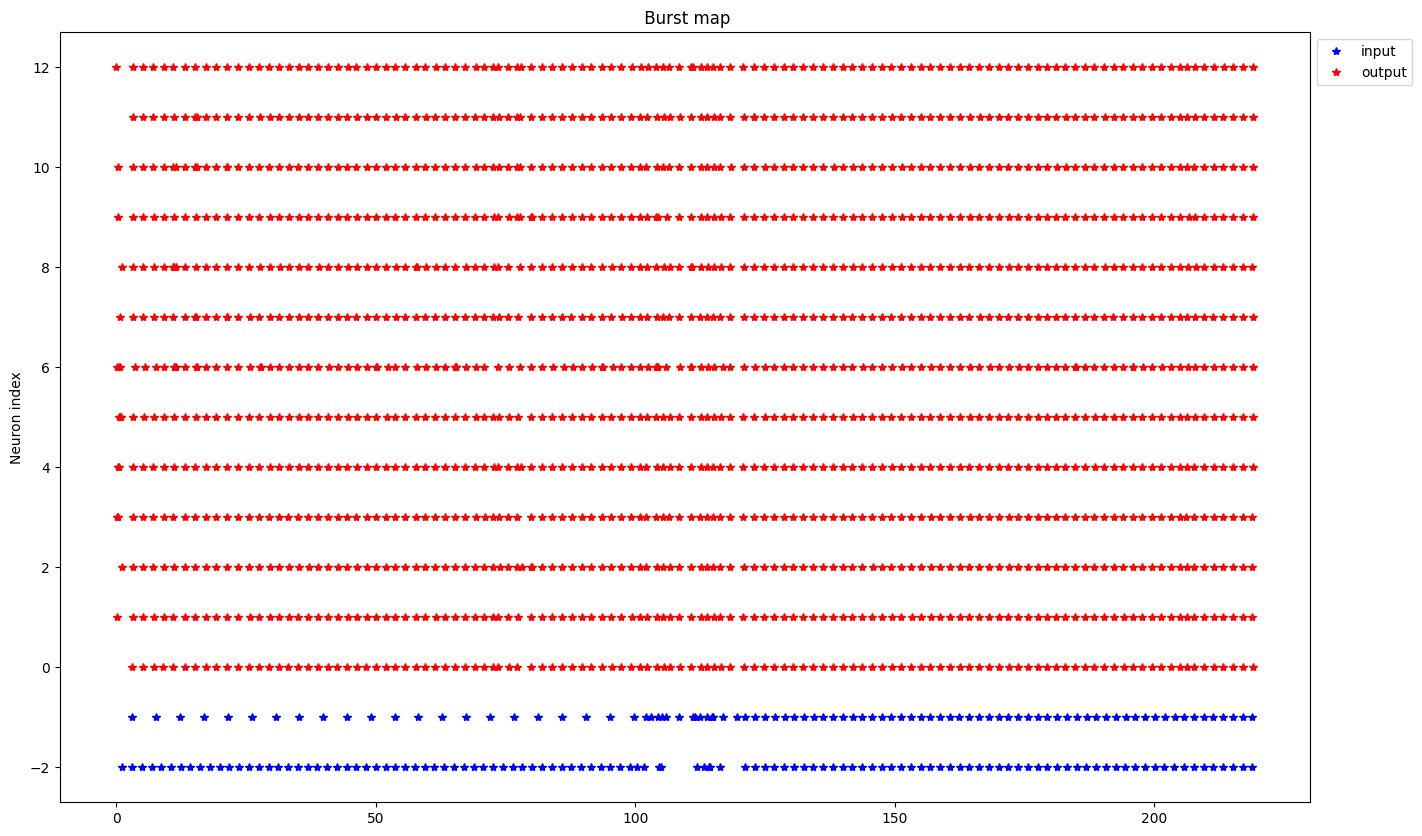

In [46]:
plt.figure(figsize=(20, 10))
plot(input_spike_monitor.t/us, input_spike_monitor.i+np.array([-n_input for i in range(len(input_spike_monitor.i))]), '*b',label='input')
plot(output_spike_monitor.t/us, output_spike_monitor.i, '*r',label='output')
plt.ylabel('Neuron index')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.subplots_adjust(right=0.75)
plt.title(" Burst map")
plt.show()

# Calculation of the mean standard deviation of the previously described random noise.




In [47]:
# Importing the .csv file of firing rate depending on the input current from PSL results
csv_file_path = 'FT_augmented.csv' #Activation function 

input_current = []
spike_rate = []

# Open the CSV file
with open(csv_file_path, 'r') as file:
    csv_reader = csv.reader(file, delimiter='\t')
    # Skip the header row
    next(csv_reader)
    for row in csv_reader:
        values = re.split(r',', row[0])
        input_current.append(float(values[0]))
        spike_rate.append(float(values[1]))
        

        
def reducing_list(original_list, new_size):
    '''
        Function that reduces the size of a list and lessen the amount of computation
    In input:
        - Original_list: list you want to reduce in size
        - new_size: size desired for the list
    It returns:
        - Similar list with desired size
    '''
    original_size = len(original_list)
    if new_size >= original_size:
        return original_list  

    # Calculate the sampling interval
    interval = original_size / new_size

    # Sample elements at regular intervals
    new_list = [original_list[int(i * interval)] for i in range(new_size)]

    return new_list


nb_point_interpolation = 1001
# Force Brian to use numpy for code generation
prefs.codegen.target = 'numpy'

# Here I reduced the size of the data to accelerate the next processus
i_new = reducing_list(input_current,nb_point_interpolation)
f_new = reducing_list(spike_rate,nb_point_interpolation)

# Convert data to use with Brian2
i_new = i_new * amp  # Now x2 is in amperes
f_new = f_new * Hz      # Now y2 is in amperes (ensure this is the correct unit!)

interp_function = interp1d(i_new, f_new, fill_value='extrapolate')

@check_units(x=amp, result = Hz)
def y_interp_function(x):
    return interp_function(x)*Hz

In [48]:
q, R_ds,C_m,scale = 1.602176634*1e-19*amp*second, 1*1e6*ohm, 9.83*1e-15*second/ohm,10
frequency_min = 0.1*Hz
avoid_error = 0.01*pA
idx_spk = 1
v_reset = -100*mV
v_threshold = 60*mV  

I_total = 2*nA
frequency = y_interp_function(I_total) # Hz 
print(" frequency = ", frequency)

sigma = sqrt(idx_spk)*sqrt(scale*q/(I_total+avoid_error)*(1/(frequency+frequency_min) + R_ds*C_m/pi)) # second; standart deviation
print(" sigma = ", sigma)

sigma_volt = sigma * (v_threshold-v_reset)*frequency
print(" sigma_volt = ", sigma_volt)

 frequency =  0.53114377 MHz
 sigma =  38.86812699 ns
 sigma_volt =  3.30313016 mV


In [49]:
# Integration from 5µA to 15nA:

sigma_list = []
for i_current in np.linspace(0.005,15,1000):
    i_current = i_current*nA
    frequency = y_interp_function(i_current) # Hz 
    sigma = sqrt(idx_spk)*sqrt(scale*q/(i_current+avoid_error)*(1/(frequency+frequency_min) + R_ds*C_m/pi)) # second; standart deviation
    sigma_volt = sigma * (v_threshold-v_reset)*frequency
    
    sigma_list.append(sigma_volt)
    
average = np.mean(sigma_list)
print(" average standard deviation = ", average*volt)

 average standard deviation =  2.37625493 mV


## Plotting the standard-deviation of the random noise depending on the spike occurence

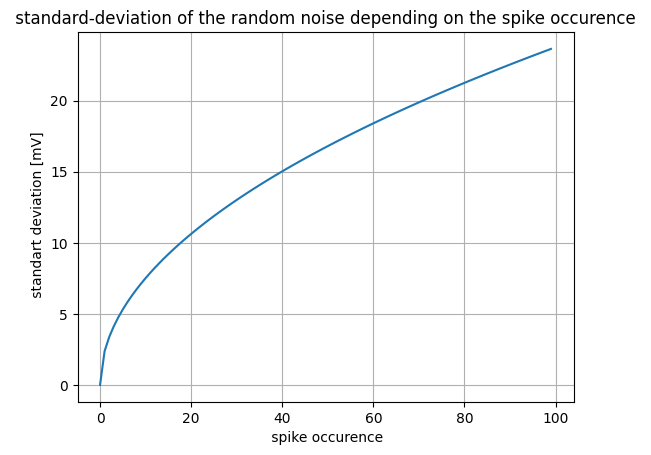

In [50]:
q, R_ds,C_m,scale = 1.602176634*1e-19*amp*second, 1*1e6*ohm, 9.83*1e-15*second/ohm,10
frequency_min = 0.1*Hz
avoid_error = 0.01*pA
v_reset = -100*mV
v_threshold = 60*mV  

I_total = 10*nA
frequency = y_interp_function(I_total) # Hz 
n_point = 100

# Integration from 5µA to 15nA:

sigma_evol = []
for idx_spk in range(n_point):
    sigma_list = []
    for i_current in np.linspace(0.005,15,1000):
        i_current = i_current*nA
        frequency = y_interp_function(i_current) # Hz 
        sigma = sqrt(idx_spk)*sqrt(scale*q/(i_current+avoid_error)*(1/(frequency+frequency_min) + R_ds*C_m/pi)) # second; standart deviation
        sigma_volt = sigma * (v_threshold-v_reset)*frequency

        sigma_list.append(sigma_volt)

    average = np.mean(sigma_list)
    
    sigma_evol.append(np.mean(sigma_list))
    
sigma_evol = np.array(sigma_evol)
plt.figure()
plt.plot(range(n_point),sigma_evol*1000,label="sigma")
title(' standard-deviation of the random noise depending on the spike occurence ')
xlabel(' spike occurence')
ylabel(' standart deviation [mV]')
plt.grid(True)
plt.show()